<a href="https://colab.research.google.com/github/antonio-datascience/Projetos-Faculdade/blob/main/atividade_2_analise_airbnb_nyc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install nb-clean

<small>Antonio Paulo Mendes Junior\
Ciência de Dados e Machine Learning\
RA: 22551431\
Introdução à Ciência de Dados\
Professor: Fabio Oliveira Guimaraes</small>

# Análise Descritiva dos Preços - Airbnb Nova York 2019

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import zipfile
import warnings
warnings.filterwarnings("ignore")

# --- Carregar o dataset a partir do arquivo ZIP ---
zip_path = "archive.zip"
with zipfile.ZipFile(zip_path, 'r') as z:
    name = [n for n in z.namelist() if n.lower().endswith('.csv')][0]
    with z.open(name) as f:
        df = pd.read_csv(f)

df.shape, df.columns.tolist()[:20]


((9742, 3), ['movieId', 'imdbId', 'tmdbId'])

In [ ]:
display(df.head())

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [ ]:
import requests

url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip" # Replace with the actual URL of your archive.zip file
zip_path = "archive.zip"

response = requests.get(url)
if response.status_code == 200:
    with open(zip_path, 'wb') as f:
        f.write(response.content)
    print(f"Downloaded {zip_path}")
else:
    print(f"Failed to download {zip_path}. Status code: {response.status_code}")

Downloaded archive.zip


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

# --- Carregar o dataset a partir do arquivo CSV ---
csv_path = "/content/AB_NYC_2019.csv"
df = pd.read_csv(csv_path)

df.shape, df.columns.tolist()[:20]

((48895, 16),
 ['id',
  'name',
  'host_id',
  'host_name',
  'neighbourhood_group',
  'neighbourhood',
  'latitude',
  'longitude',
  'room_type',
  'price',
  'minimum_nights',
  'number_of_reviews',
  'last_review',
  'reviews_per_month',
  'calculated_host_listings_count',
  'availability_365'])

## 1.1 Análise Descritiva dos Preços

In [ ]:
# Fazendo as Estatísticas descritivas da variável price
price = df['price'].dropna()
mean_price = price.mean()
median_price = price.median()
mode_price = price.mode().tolist()
std_price = price.std()
var_price = price.var()
q1 = price.quantile(0.25)
q2 = price.quantile(0.5)
q3 = price.quantile(0.75)
iqr = q3 - q1
cv = std_price / mean_price
skewness = stats.skew(price)
kurtosis = stats.kurtosis(price)

print(f"Média: {mean_price:.2f}\nMediana: {median_price}\nModa: {mode_price}\nDesvio padrão: {std_price:.2f}\nVariância: {var_price:.2f}\nQ1: {q1}\nQ3: {q3}\nIQR: {iqr}\nCV: {cv:.2f}\nAssimetria: {skewness:.2f}\nCurtose: {kurtosis:.2f}")

Média: 152.72
Mediana: 106.0
Moda: [100]
Desvio padrão: 240.15
Variância: 57674.03
Q1: 69.0
Q3: 175.0
IQR: 106.0
CV: 1.57
Assimetria: 19.12
Curtose: 585.61


### Identificação de outliers (IQR)

In [ ]:
# Identificando os outliers nos preços usando o método IQR
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
outliers = df[(df['price'] < lower) | (df['price'] > upper)]
print(f"Limite inferior: {lower}\nLimite superior: {upper}\nTotal de outliers: {outliers.shape[0]}")
outliers.head()


Limite inferior: -90.0
Limite superior: 334.0
Total de outliers: 2972


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
61,15396,Sunny & Spacious Chelsea Apartment,60278,Petra,Manhattan,Chelsea,40.74623,-73.99530,Entire home/apt,375,180,5,2018-11-03,0.12,1,180
85,19601,perfect for a family or small group,74303,Maggie,Brooklyn,Brooklyn Heights,40.69723,-73.99268,Entire home/apt,800,1,25,2016-08-04,0.24,1,7
103,23686,2000 SF 3br 2bath West Village private townhouse,93790,Ann,Manhattan,West Village,40.73096,-74.00319,Entire home/apt,500,4,46,2019-05-18,0.55,2,243
114,26933,2 BR / 2 Bath Duplex Apt with patio! East Village,72062,Bruce,Manhattan,East Village,40.72540,-73.98157,Entire home/apt,350,2,7,2017-08-09,0.06,4,298
121,27659,3 Story Town House in Park Slope,119588,Vero,Brooklyn,South Slope,40.66499,-73.97925,Entire home/apt,400,2,16,2018-12-30,0.24,2,216


### Comparação de preços entre tipos de quarto

In [ ]:
# Fazendo a comparação de preços entre os tipos de quarto
room_summary = df.groupby('room_type')['price'].agg(['count','mean','median','std']).reset_index()
room_summary


,room_type,count,mean,median,std
0,Entire home/apt,25409,211.794246,160.0,284.041611
1,Private room,22326,89.780973,70.0,160.205262
2,Shared room,1160,70.127586,45.0,101.725252


### Correlações e Relacionamentos

In [ ]:
# - preço x número de reviews
# - preço x avaliação (review_scores_rating)
# - mínimo de noites x preço
corr1 = df['price'].corr(df['number_of_reviews'])
corr2 = df['price'].corr(df['reviews_per_month'])
corr3 = df['price'].corr(df['minimum_nights'])

print(f"Correlação preço x nº reviews: {corr1:.4f}\nCorrelação preço x reviews_per_month: {corr2:.4f}\nCorrelação preço x mínimo de noites: {corr3:.4f}")


Correlação preço x nº reviews: -0.0480
Correlação preço x reviews_per_month: -0.0306
Correlação preço x mínimo de noites: 0.0428


## 2.1 Visualizações Obrigatórias

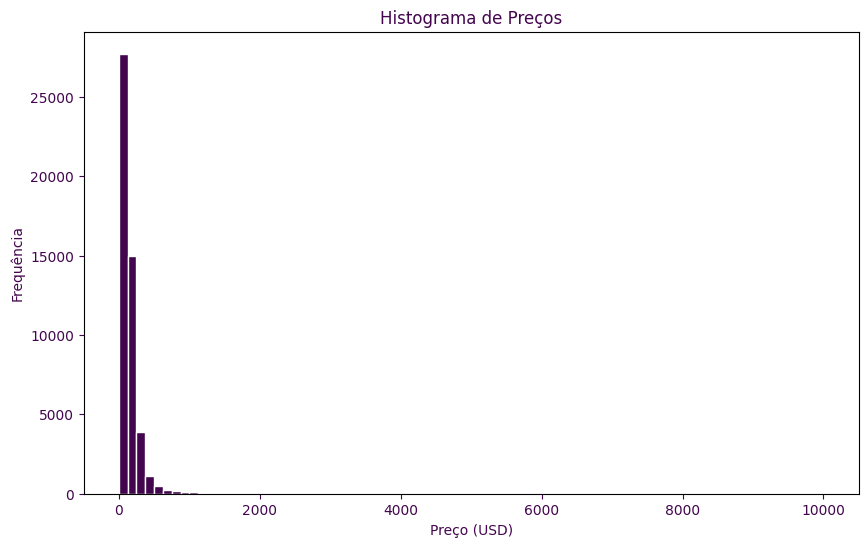

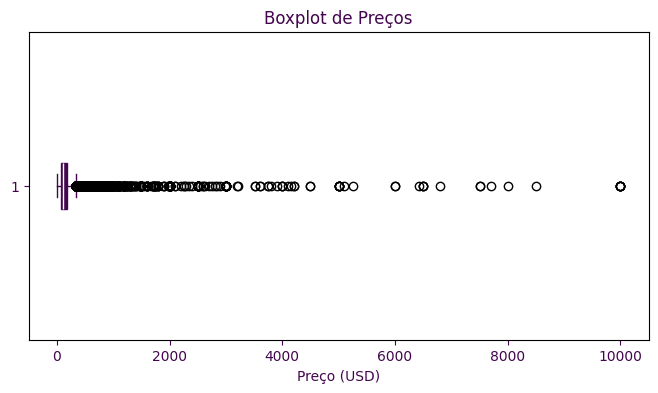

In [ ]:
# Histograma + Boxplot dos preços
import matplotlib.pyplot as plt

# Cor personalizada
cor_principal = "#43054e"

# Histograma de Preços
plt.figure(figsize=(10,6))
plt.hist(price, bins=80, color=cor_principal, edgecolor='white')
plt.title("Histograma de Preços", color=cor_principal)
plt.xlabel("Preço (USD)", color=cor_principal)
plt.ylabel("Frequência", color=cor_principal)
plt.tick_params(colors=cor_principal)
plt.show()

# Boxplot de Preços
plt.figure(figsize=(8,4))
plt.boxplot(price, vert=False, patch_artist=True,
            boxprops=dict(facecolor=cor_principal, color=cor_principal),
            whiskerprops=dict(color=cor_principal),
            capprops=dict(color=cor_principal),
            medianprops=dict(color='white'))
plt.title("Boxplot de Preços", color=cor_principal)
plt.xlabel("Preço (USD)", color=cor_principal)
plt.tick_params(colors=cor_principal)
plt.show()

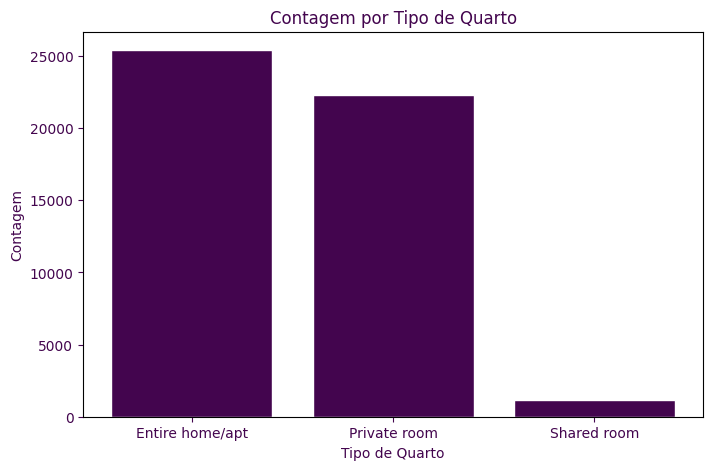

In [ ]:
# Fazendo a contagem por categoria
import matplotlib.pyplot as plt

# Cor personalizada
cor_principal = "#43054e"

# Contagem por tipo de quarto
counts = df['room_type'].value_counts()
plt.figure(figsize=(8,5))
plt.bar(counts.index, counts.values, color=cor_principal, edgecolor='white')
plt.title("Contagem por Tipo de Quarto", color=cor_principal)
plt.xlabel("Tipo de Quarto", color=cor_principal)
plt.ylabel("Contagem", color=cor_principal)
plt.tick_params(colors=cor_principal)
plt.xticks(color=cor_principal)
plt.yticks(color=cor_principal)
plt.show()


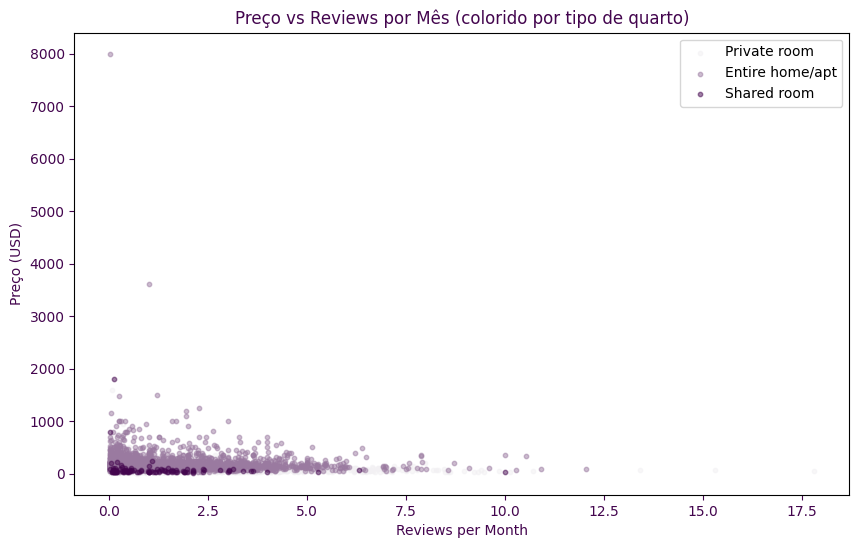

In [ ]:
# Scatter plot preço vs. avaliação
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Paleta base
base_color = "#43054e"

# Amostra dos dados
sample = df.dropna(subset=['price','reviews_per_month','room_type']).sample(n=min(5000, len(df)), random_state=1)

# Geração de gradientes por tipo de quarto
room_types = sample['room_type'].unique()
colors = sns.light_palette(base_color, n_colors=len(room_types), input="hex")

# Mapeia cada tipo de quarto para uma cor gradiente
color_map = dict(zip(room_types, colors))

# Gráfico de dispersão
plt.figure(figsize=(10,6))
for rt in room_types:
    subset = sample[sample['room_type'] == rt]
    plt.scatter(subset['reviews_per_month'], subset['price'],
                alpha=0.5, label=rt, s=10, color=color_map[rt])
plt.xlabel("Reviews per Month", color=base_color)
plt.ylabel("Preço (USD)", color=base_color)
plt.title("Preço vs Reviews por Mês (colorido por tipo de quarto)", color=base_color)
plt.legend()
plt.tick_params(colors=base_color)
plt.xticks(color=base_color)
plt.yticks(color=base_color)
plt.show()



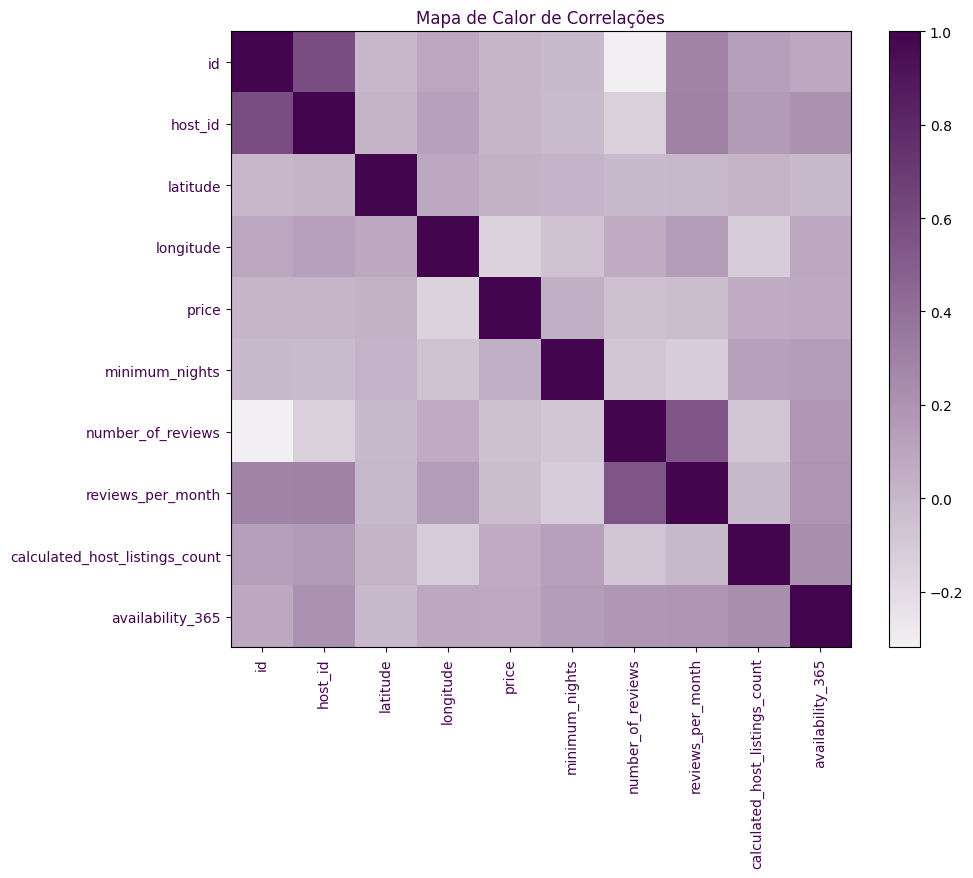

In [ ]:
# Mapa de calor de correlações entre variáveis numéricas
import matplotlib.pyplot as plt
import seaborn as sns

# Paleta personalizada baseada em #43054e
cmap_personalizado = sns.light_palette("#43054e", as_cmap=True)

# Matriz de correlação
corr_matrix = df.select_dtypes(include=[np.number]).corr()

# Gráfico de calor
plt.figure(figsize=(10,8))
im = plt.imshow(corr_matrix, interpolation='none', aspect='auto', cmap=cmap_personalizado)
plt.colorbar(im)
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=90, color="#43054e")
plt.yticks(range(len(corr_matrix)), corr_matrix.columns, color="#43054e")
plt.title("Mapa de Calor de Correlações", color="#43054e")
plt.tick_params(colors="#43054e")
plt.show()



## 2.2 — Visualizações Criativas

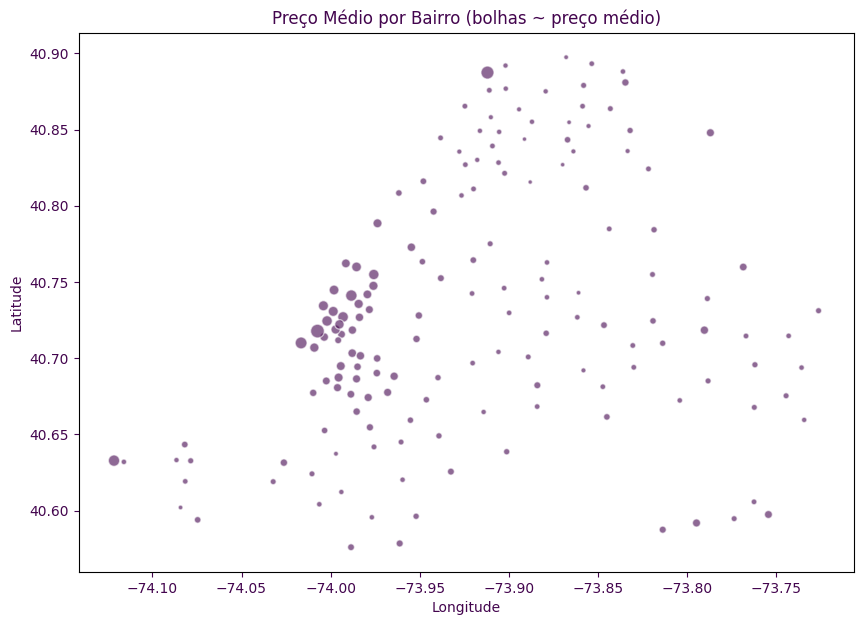

In [ ]:
# Preço médio por Bairro
import matplotlib.pyplot as plt

# Cor personalizada
cor_principal = "#43054e"

# Agrupamento e filtragem
mean_loc = df.groupby('neighbourhood').agg({
    'latitude': 'mean',
    'longitude': 'mean',
    'price': 'mean',
    'id': 'count'
}).rename(columns={'id': 'count'}).reset_index()

mean_loc_filt = mean_loc[mean_loc['count'] > 10]

# Gráfico de dispersão com bolhas
plt.figure(figsize=(10,7))
plt.scatter(
    mean_loc_filt['longitude'],
    mean_loc_filt['latitude'],
    s=(mean_loc_filt['price'] / 5),
    alpha=0.6,
    color=cor_principal,
    edgecolors='white'
)
plt.title("Preço Médio por Bairro (bolhas ~ preço médio)", color=cor_principal)
plt.xlabel("Longitude", color=cor_principal)
plt.ylabel("Latitude", color=cor_principal)
plt.tick_params(colors=cor_principal)
plt.xticks(color=cor_principal)
plt.yticks(color=cor_principal)
plt.show()



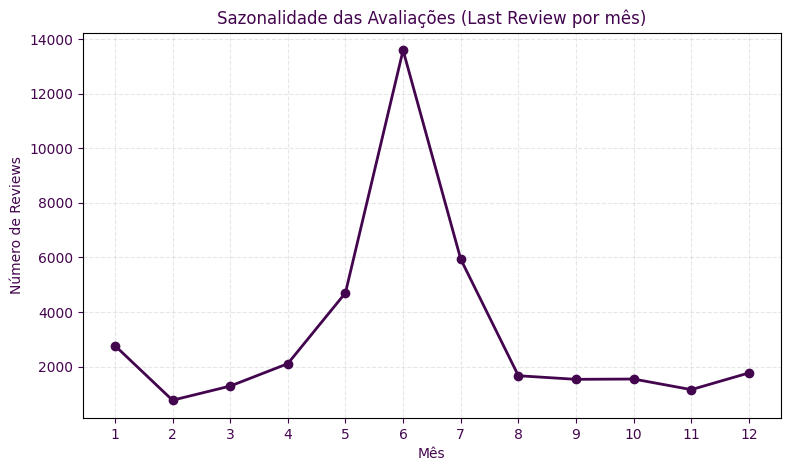

In [ ]:
# Sazonalidade das avaliações
import matplotlib.pyplot as plt

# Cor personalizada
cor_principal = "#43054e"

# Conversão e agrupamento
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
df['month'] = df['last_review'].dt.month
monthly = df.groupby('month').size().reindex(range(1,13), fill_value=0)

# Gráfico de linha
plt.figure(figsize=(9,5))
plt.plot(monthly.index, monthly.values, marker='o', color=cor_principal, linewidth=2)
plt.title("Sazonalidade das Avaliações (Last Review por mês)", color=cor_principal)
plt.xlabel("Mês", color=cor_principal)
plt.ylabel("Número de Reviews", color=cor_principal)
plt.xticks(range(1,13), color=cor_principal)
plt.yticks(color=cor_principal)
plt.tick_params(colors=cor_principal)
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()



## Conclusões

- A variável `price` apresenta alta assimetria positiva e grande número de outliers acima de 334 USD.
- `Entire home/apt` é o tipo de quarto mais caro, com média ~212 USD.
- Correlações entre preço e reviews são fracas.
- As visualizações mostram concentração de preços baixos e forte cauda longa.